In [1]:
import os
import gc
import sys
import joblib
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime
from argparse import Namespace
from collections import defaultdict
from scipy.signal import find_peaks

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, GroupKFold, train_test_split, KFold

import lightgbm as lgb
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 64)

def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [2]:
args = Namespace(
    train=False,
    optimize=False,
    train_l2=True,
    debug=False,
    seed=21,
    folds=5,
    workers=4,
    min_time_id=None, 
    holdout=False,
    cv_method="single",
    num_bins=16,
    holdout_size=100,
    outlier_threshold=0.005,
    trading_days_per_year=250,   # chinese stock market trading days per year (roughly)
    add_investment_id_model=False,
    additional_features=True,
    data_path=Path(""),
    just_eda=True,
)
seed_everything(args.seed)

if args.debug:
    setattr(args, 'min_time_id', 1150)

assert args.cv_method in {"single", "kfold", "group", "stratified", "time", "group_time", "time_range"}, "unknown cv method"
assert args.data_path.exists(), "data_path not exists"

In [3]:
%%time
train = pd.read_parquet(args.data_path.joinpath("train_low_mem.parquet"))
# assert train.isnull().any().sum() == 0, "null exists."
# assert train.row_id.str.extract(r"(?P<time_id>\d+)_(?P<investment_id>\d+)").astype(train.time_id.dtype).equals(train[["time_id", "investment_id"]]), "row_id!=time_id_investment_id"
# assert train.time_id.is_monotonic_increasing, "time_id not monotonic increasing"

CPU times: user 2.99 s, sys: 821 ms, total: 3.81 s
Wall time: 3.81 s


# Features EDA + processing

### Maybe outliers

In [4]:
train[['target']]

,target
0,-0.300875
1,-0.231040
2,0.568807
3,-1.064780
4,-0.531940
...,...
3141405,0.033600
3141406,-0.223264
3141407,-0.559415
3141408,0.009599


In [5]:
train[['target']].quantile([1-0.005, 0.005])

,target
0.995,3.783038
0.005,-2.703471


In [6]:
args.outlier_threshold

0.005

In [7]:
train[["investment_id", "target"]].groupby("investment_id").target.mean()

investment_id
0       0.052841
1      -0.025687
2      -0.051106
3       0.046773
4      -0.047773
          ...   
3768   -0.027151
3769   -0.028946
3770   -0.073020
3772   -0.013986
3773   -0.015845
Name: target, Length: 3579, dtype: float32

0.10802400507032894

-0.22408594757318495

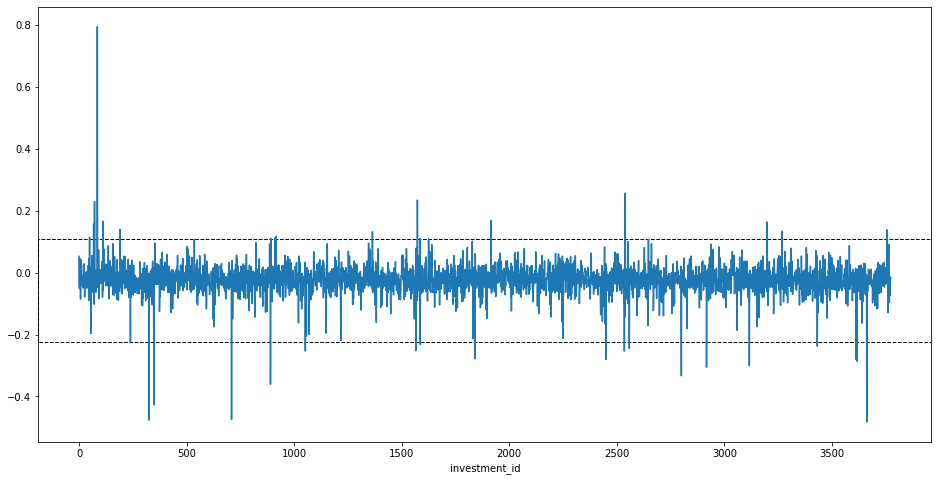

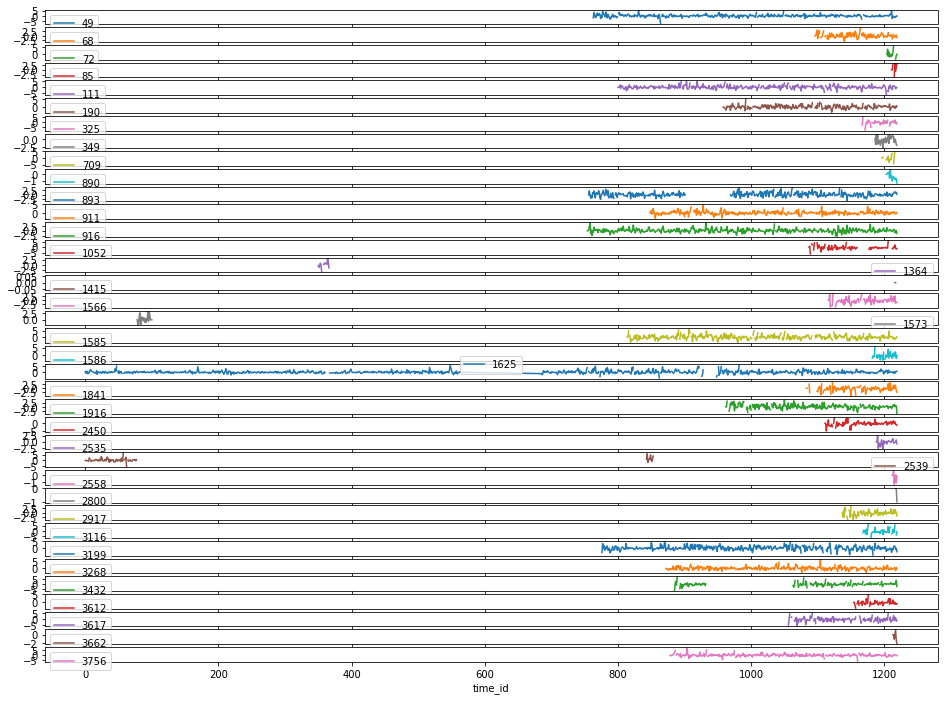

In [8]:
df = train[["investment_id", "target"]].groupby("investment_id").target.mean()
upper_bound, lower_bound = df.quantile([1-args.outlier_threshold, args.outlier_threshold])
display(upper_bound, lower_bound)
ax = df.plot(figsize=(16, 8))
ax.axhspan(lower_bound, upper_bound, fill=False, linestyle="--", color="k")
plt.show()

outlier_investments = df.loc[(df>upper_bound)|(df<lower_bound)|(df==0)].index
_=pd.pivot(
    train.loc[train.investment_id.isin(outlier_investments), ["investment_id", "time_id", "target"]],
    index='time_id', columns='investment_id', values='target'
).plot(figsize=(16,12), subplots=True, sharex=True)

# Drop indexes with feature outliers: [notebook](https://www.kaggle.com/junjitakeshima/ubiquant-simple-lgbm-removing-outliers-en-jp)

In [9]:
outlier_list = []
outlier_col = []

for col in (f"f_{i}" for i in range(300)):
    _mean, _std = train[col].mean(), train[col].std()
    
    temp_df = train.loc[(train[col] > _mean + _std * 70) | (train[col] < _mean - _std * 70)]
    temp2_df = train.loc[(train[col] > _mean + _std * 35) | (train[col] < _mean - _std * 35)]
    if len(temp_df) >0 : 
        outliers = temp_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp_df))
    elif len(temp2_df)>0 and len(temp2_df) <6 :
        outliers = temp2_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp2_df))

outlier_list = list(set(outlier_list))
train.drop(train.index[outlier_list], inplace=True)
print(len(outlier_col), len(outlier_list), train.shape)

f_4 6
f_10 1
f_12 1
f_13 1
f_37 3
f_49 1
f_55 2
f_62 1
f_77 5
f_78 1
f_87 3
f_99 3
f_104 1
f_108 5
f_115 14
f_117 16
f_118 2
f_122 2
f_124 17
f_127 16
f_128 5
f_136 2
f_137 1
f_145 2
f_149 2
f_155 2
f_162 1
f_165 1
f_172 2
f_174 1
f_175 30
f_179 3
f_193 3
f_196 1
f_197 1
f_200 37
f_209 5
f_214 1
f_215 1
f_219 1
f_233 3
f_249 1
f_250 4
f_265 1
f_277 1
f_280 3
f_289 6
f_295 1
48 173 (3141237, 304)


### Drop outliers from train

In [10]:
if args.min_time_id is not None:
    train = train.query("time_id>=@args.min_time_id").reset_index(drop=True)
    gc.collect()
    
train=train.loc[~train.investment_id.isin(outlier_investments)].reset_index(drop=True)
train.shape

(3134708, 304)

### Strange behaviour of some features according to time id

### f_1

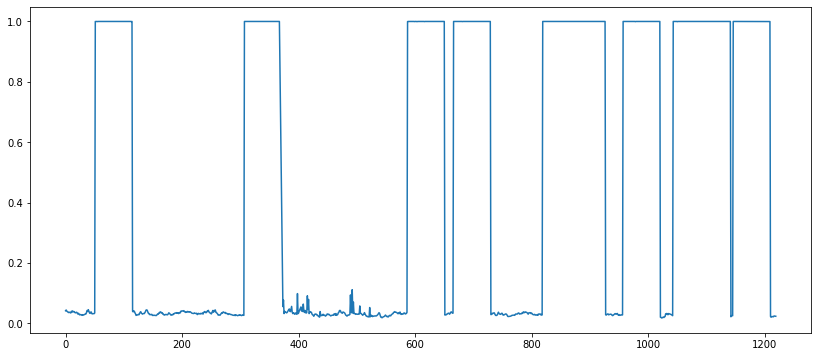

In [11]:
def get_unique_total_values_ratio(df, feature, plot=False, return_result=False):
    df_date_group = df.groupby('time_id').agg({feature: [lambda x: len(x.unique()), 'count']})
    df_date_group.columns.set_levels(['len_unique','count'], level=1,inplace=True)
    df_date_group['unique_count_ratio'] = df_date_group[feature]['len_unique']/df_date_group[feature]['count']
    df_date_group['num_or_cat'] = df_date_group['unique_count_ratio'].apply(lambda x: 1 if x > 0.5 else 0)
    if plot:
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(111)
        plt.plot(df_date_group.index, df_date_group['unique_count_ratio'] , label="Number of unique investments")
    if return_result:
        return df_date_group['num_or_cat']

get_unique_total_values_ratio(train, 'f_1', plot=True)

### f_6

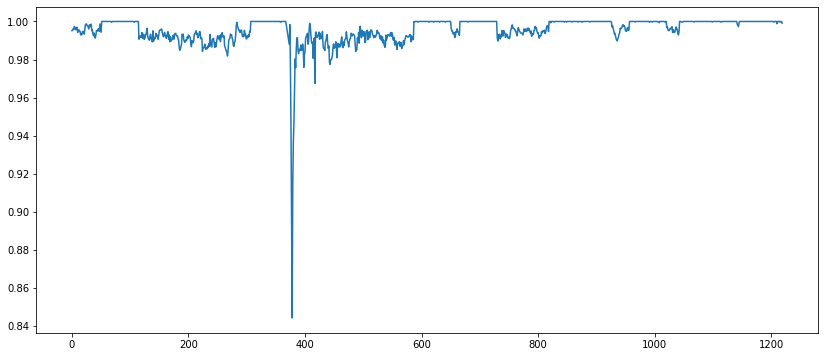

In [12]:
get_unique_total_values_ratio(train, 'f_6', plot=True)

### f_7

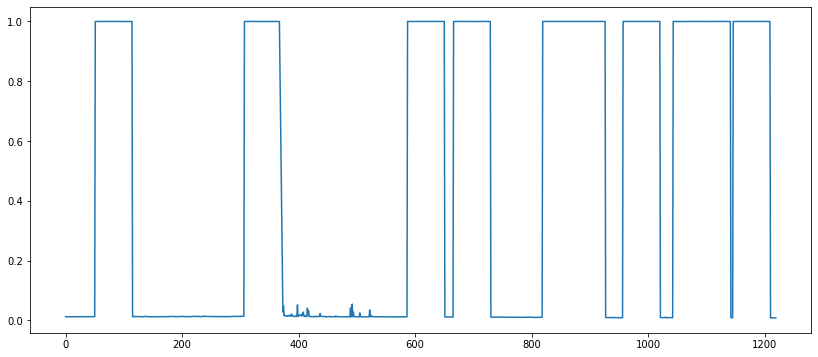

In [13]:
num_or_cat = get_unique_total_values_ratio(train, 'f_7', plot=True, return_result=True)

### Add time_id features

In [14]:
time_id_df = (
    train[["investment_id", "time_id"]]
    .groupby("investment_id")
    .agg(["min", "max", "count", np.ptp])
    .assign(
        time_span=lambda x: x.time_id.ptp,
        time_count=lambda x: x.time_id["count"]
    )
    .drop(columns="ptp", level=1)
    .reset_index()
)
time_id_df.head(6)

investment_id time_id             time_span time_count
                    min   max count                     
0             0     757  1219   461       462        461
1             1       0  1219  1108      1219       1108
2             2       0  1219  1003      1219       1003
3             3      27  1219  1073      1192       1073
4             4     885  1219   316       334        316
5             6       0  1219  1082      1219       1082

### Merge time features with train dataframe

9355

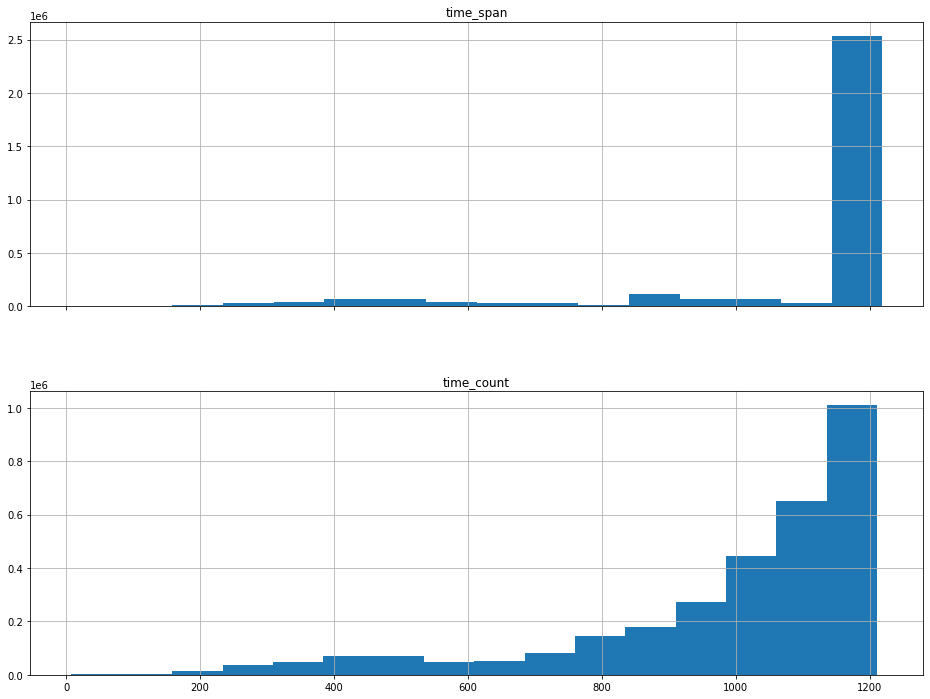

In [15]:
train = train.merge(time_id_df.drop(columns="time_id", level=0).droplevel(level=1, axis=1), on="investment_id", how='left')
train[["time_span", "time_count"]].hist(bins=args.num_bins, figsize=(16,12), sharex=True, layout=(2,1))
max_time_span=time_id_df.time_id["max"].max()
outlier_investments = time_id_df.loc[time_id_df.time_id["count"]<32, "investment_id"].to_list()
del time_id_df
gc.collect()

### Make combinations for some features and drop not necessary features.

In [16]:
cat_features = ['num_or_cat']
num_features = list(train.filter(like="f_").columns)
features = num_features + cat_features

# make feature combinations
combination_features = ["f_231-f_250", "f_118-f_280", "f_155-f_297", "f_25-f_237", "f_179-f_265", "f_119-f_270", "f_71-f_197", "f_21-f_65"]
for f in combination_features:
    f1, f2 = f.split("-")
    train[f] = train[f1] + train[f2]
features += combination_features

# drop unnecessary features
to_drop = ["f_148", "f_72", "f_49", "f_205", "f_228", "f_97", "f_262", "f_258"]
features = list(sorted(set(features).difference(set(to_drop))))

# add numerical/categorical flag
train = train.merge(num_or_cat, how='left', on='time_id')

# add clusters
# inv_id_to_a_share = pd.read_csv('inv_id_to_a_share.csv')
# train = train.merge(inv_id_to_a_share[['investment_id', 'sector']], how='left', on='investment_id')

# add groups based on time_id
# train.loc[(train['time_id'] >= 0) & (train['time_id'] < 280), 'group'] = 0
# train.loc[(train['time_id'] >= 280) & (train['time_id'] < 585), 'group'] = 1
# train.loc[(train['time_id'] >= 585) & (train['time_id'] < 825), 'group'] = 2
# train.loc[(train['time_id'] >= 825) & (train['time_id'] < 1030), 'group'] = 3
# train.loc[(train['time_id'] >= 1030) & (train['time_id'] < 1400), 'group'] = 4
train.loc[(train['time_id'] < 910), 'group'] = 0
train.loc[(train['time_id'] >= 910) & (train['time_id'] < 970), 'group'] = 1
train.loc[(train['time_id'] >= 970) & (train['time_id'] < 1030), 'group'] = 2
train.loc[(train['time_id'] >= 1030) & (train['time_id'] < 1090), 'group'] = 3
train.loc[(train['time_id'] >= 1090) & (train['time_id'] < 1150), 'group'] = 4
train.loc[(train['time_id'] >= 1150), 'group'] = 5
train['group'] = train['group'].astype(np.int16)

### Reduce memory usage.

In [17]:
%%time

train = reduce_mem_usage(train)
train[["investment_id", "time_id"]] = train[["investment_id", "time_id"]].astype(np.uint16)
train=train.drop(columns=["row_id"]+to_drop)

if args.cv_method=="stratified":
    train["fold"] = train["fold"].astype(np.uint8)
gc.collect()
#features += ["time_id"] # https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302429
features_backup = features.copy()
len(features)

Memory usage of dataframe is 3814.59 MB
Memory usage after optimization is: 2001.69 MB
Decreased by 47.5%
CPU times: user 1min 1s, sys: 35.4 s, total: 1min 36s
Wall time: 1min 36s


301

# Split + holdout

### StratifiedKFold by time_span: [discussion](https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302429)

In [18]:
# # https://www.kaggle.com/joelqv/grouptimeseriescv-catboost-gpu
# from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
# from sklearn.utils.validation import _deprecate_positional_args

# # https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
# class GroupTimeSeriesSplit(_BaseKFold):
#     """Time Series cross-validator variant with non-overlapping groups.
#     Provides train/test indices to split time series data samples
#     that are observed at fixed time intervals according to a
#     third-party provided group.
#     In each split, test indices must be higher than before, and thus shuffling
#     in cross validator is inappropriate.
#     This cross-validation object is a variation of :class:`KFold`.
#     In the kth split, it returns first k folds as train set and the
#     (k+1)th fold as test set.
#     The same group will not appear in two different folds (the number of
#     distinct groups has to be at least equal to the number of folds).
#     Note that unlike standard cross-validation methods, successive
#     training sets are supersets of those that come before them.
#     Read more in the :ref:`User Guide <cross_validation>`.
#     Parameters
#     ----------
#     n_splits : int, default=5
#         Number of splits. Must be at least 2.
#     max_train_size : int, default=None
#         Maximum size for a single training set.
#     Examples
#     --------
#     >>> import numpy as np
#     >>> from sklearn.model_selection import GroupTimeSeriesSplit
#     >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
#                            'b', 'b', 'b', 'b', 'b',\
#                            'c', 'c', 'c', 'c',\
#                            'd', 'd', 'd'])
#     >>> gtss = GroupTimeSeriesSplit(n_splits=3)
#     >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
#     ...     print("TRAIN:", train_idx, "TEST:", test_idx)
#     ...     print("TRAIN GROUP:", groups[train_idx],\
#                   "TEST GROUP:", groups[test_idx])
#     TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
#     TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
#     TEST GROUP: ['b' 'b' 'b' 'b' 'b']
#     TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
#     TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
#     TEST GROUP: ['c' 'c' 'c' 'c']
#     TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
#     TEST: [15, 16, 17]
#     TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
#     TEST GROUP: ['d' 'd' 'd']
#     """

#     @_deprecate_positional_args
#     def __init__(self, n_splits=5, *, max_train_size=None):
#         super().__init__(n_splits, shuffle=False, random_state=None)
#         self.max_train_size = max_train_size

#     def split(self, X, y=None, groups=None):
#         """Generate indices to split data into training and test set.
#         Parameters
#         ----------
#         X : array-like of shape (n_samples, n_features)
#             Training data, where n_samples is the number of samples
#             and n_features is the number of features.
#         y : array-like of shape (n_samples,)
#             Always ignored, exists for compatibility.
#         groups : array-like of shape (n_samples,)
#             Group labels for the samples used while splitting the dataset into
#             train/test set.
#         Yields
#         ------
#         train : ndarray
#             The training set indices for that split.
#         test : ndarray
#             The testing set indices for that split.
#         """
#         if groups is None:
#             raise ValueError("The 'groups' parameter should not be None")
#         X, y, groups = indexable(X, y, groups)
#         n_samples = _num_samples(X)
#         n_splits = self.n_splits
#         n_folds = n_splits + 1
#         group_dict = {}
#         u, ind = np.unique(groups, return_index=True)
#         unique_groups = u[np.argsort(ind)]
#         n_samples = _num_samples(X)
#         n_groups = _num_samples(unique_groups)
#         for idx in np.arange(n_samples):
#             if groups[idx] in group_dict:
#                 group_dict[groups[idx]].append(idx)
#             else:
#                 group_dict[groups[idx]] = [idx]
#         if n_folds > n_groups:
#             raise ValueError(
#                 (
#                     "Cannot have number of folds={0} greater than"
#                     " the number of groups={1}"
#                 ).format(n_folds, n_groups)
#             )
#         group_test_size = n_groups // n_folds
#         group_test_starts = range(
#             n_groups - n_splits * group_test_size, n_groups, group_test_size
#         )
#         for group_test_start in group_test_starts:
#             train_array = []
#             test_array = []
#             for train_group_idx in unique_groups[:group_test_start]:
#                 train_array_tmp = group_dict[train_group_idx]
#                 train_array = np.sort(
#                     np.unique(
#                         np.concatenate((train_array, train_array_tmp)), axis=None
#                     ),
#                     axis=None,
#                 )
#             train_end = train_array.size
#             if self.max_train_size and self.max_train_size < train_end:
#                 train_array = train_array[train_end - self.max_train_size : train_end]
#             for test_group_idx in unique_groups[
#                 group_test_start : group_test_start + group_test_size
#             ]:
#                 test_array_tmp = group_dict[test_group_idx]
#                 test_array = np.sort(
#                     np.unique(np.concatenate((test_array, test_array_tmp)), axis=None),
#                     axis=None,
#                 )
#             yield [int(i) for i in train_array], [int(i) for i in test_array]
            
# from sklearn.utils import check_random_state
# from sklearn.utils.multiclass import type_of_target
# from sklearn.utils.validation import _num_samples, column_or_1d
        
# class StratifiedGroupKFold(_BaseKFold):
#     """Stratified K-Folds iterator variant with non-overlapping groups.
#     This cross-validation object is a variation of StratifiedKFold attempts to
#     return stratified folds with non-overlapping groups. The folds are made by
#     preserving the percentage of samples for each class.
#     The same group will not appear in two different folds (the number of
#     distinct groups has to be at least equal to the number of folds).
#     The difference between GroupKFold and StratifiedGroupKFold is that
#     the former attempts to create balanced folds such that the number of
#     distinct groups is approximately the same in each fold, whereas
#     StratifiedGroupKFold attempts to create folds which preserve the
#     percentage of samples for each class as much as possible given the
#     constraint of non-overlapping groups between splits.
#     Read more in the :ref:`User Guide <cross_validation>`.
#     Parameters
#     ----------
#     n_splits : int, default=5
#         Number of folds. Must be at least 2.
#     shuffle : bool, default=False
#         Whether to shuffle each class's samples before splitting into batches.
#         Note that the samples within each split will not be shuffled.
#         This implementation can only shuffle groups that have approximately the
#         same y distribution, no global shuffle will be performed.
#     random_state : int or RandomState instance, default=None
#         When `shuffle` is True, `random_state` affects the ordering of the
#         indices, which controls the randomness of each fold for each class.
#         Otherwise, leave `random_state` as `None`.
#         Pass an int for reproducible output across multiple function calls.
#         See :term:`Glossary <random_state>`.
#     Examples
#     --------
#     >>> import numpy as np
#     >>> from sklearn.model_selection import StratifiedGroupKFold
#     >>> X = np.ones((17, 2))
#     >>> y = np.array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
#     >>> groups = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 8, 8])
#     >>> cv = StratifiedGroupKFold(n_splits=3)
#     >>> for train_idxs, test_idxs in cv.split(X, y, groups):
#     ...     print("TRAIN:", groups[train_idxs])
#     ...     print("      ", y[train_idxs])
#     ...     print(" TEST:", groups[test_idxs])
#     ...     print("      ", y[test_idxs])
#     TRAIN: [1 1 2 2 4 5 5 5 5 8 8]
#            [0 0 1 1 1 0 0 0 0 0 0]
#      TEST: [3 3 3 6 6 7]
#            [1 1 1 0 0 0]
#     TRAIN: [3 3 3 4 5 5 5 5 6 6 7]
#            [1 1 1 1 0 0 0 0 0 0 0]
#      TEST: [1 1 2 2 8 8]
#            [0 0 1 1 0 0]
#     TRAIN: [1 1 2 2 3 3 3 6 6 7 8 8]
#            [0 0 1 1 1 1 1 0 0 0 0 0]
#      TEST: [4 5 5 5 5]
#            [1 0 0 0 0]
#     Notes
#     -----
#     The implementation is designed to:
#     * Mimic the behavior of StratifiedKFold as much as possible for trivial
#       groups (e.g. when each group contains only one sample).
#     * Be invariant to class label: relabelling ``y = ["Happy", "Sad"]`` to
#       ``y = [1, 0]`` should not change the indices generated.
#     * Stratify based on samples as much as possible while keeping
#       non-overlapping groups constraint. That means that in some cases when
#       there is a small number of groups containing a large number of samples
#       the stratification will not be possible and the behavior will be close
#       to GroupKFold.
#     See also
#     --------
#     StratifiedKFold: Takes class information into account to build folds which
#         retain class distributions (for binary or multiclass classification
#         tasks).
#     GroupKFold: K-fold iterator variant with non-overlapping groups.
#     """

#     def __init__(self, n_splits=5, shuffle=False, random_state=None):
#         super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

#     def _iter_test_indices(self, X, y, groups):
#         # Implementation is based on this kaggle kernel:
#         # https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
#         # and is a subject to Apache 2.0 License. You may obtain a copy of the
#         # License at http://www.apache.org/licenses/LICENSE-2.0
#         # Changelist:
#         # - Refactored function to a class following scikit-learn KFold
#         #   interface.
#         # - Added heuristic for assigning group to the least populated fold in
#         #   cases when all other criteria are equal
#         # - Swtch from using python ``Counter`` to ``np.unique`` to get class
#         #   distribution
#         # - Added scikit-learn checks for input: checking that target is binary
#         #   or multiclass, checking passed random state, checking that number
#         #   of splits is less than number of members in each class, checking
#         #   that least populated class has more members than there are splits.
#         rng = check_random_state(self.random_state)
#         y = np.asarray(y)
#         type_of_target_y = type_of_target(y)
#         allowed_target_types = ("binary", "multiclass")
#         if type_of_target_y not in allowed_target_types:
#             raise ValueError(
#                 "Supported target types are: {}. Got {!r} instead.".format(
#                     allowed_target_types, type_of_target_y
#                 )
#             )

#         y = column_or_1d(y)
#         _, y_inv, y_cnt = np.unique(y, return_inverse=True, return_counts=True)
#         if np.all(self.n_splits > y_cnt):
#             raise ValueError(
#                 "n_splits=%d cannot be greater than the"
#                 " number of members in each class." % (self.n_splits)
#             )
#         n_smallest_class = np.min(y_cnt)
#         if self.n_splits > n_smallest_class:
#             warnings.warn(
#                 "The least populated class in y has only %d"
#                 " members, which is less than n_splits=%d."
#                 % (n_smallest_class, self.n_splits),
#                 UserWarning,
#             )
#         n_classes = len(y_cnt)

#         _, groups_inv, groups_cnt = np.unique(
#             groups, return_inverse=True, return_counts=True
#         )
#         y_counts_per_group = np.zeros((len(groups_cnt), n_classes))
#         for class_idx, group_idx in zip(y_inv, groups_inv):
#             y_counts_per_group[group_idx, class_idx] += 1

#         y_counts_per_fold = np.zeros((self.n_splits, n_classes))
#         groups_per_fold = defaultdict(set)

#         if self.shuffle:
#             rng.shuffle(y_counts_per_group)

#         # Stable sort to keep shuffled order for groups with the same
#         # class distribution variance
#         sorted_groups_idx = np.argsort(
#             -np.std(y_counts_per_group, axis=1), kind="mergesort"
#         )

#         for group_idx in sorted_groups_idx:
#             group_y_counts = y_counts_per_group[group_idx]
#             best_fold = self._find_best_fold(
#                 y_counts_per_fold=y_counts_per_fold,
#                 y_cnt=y_cnt,
#                 group_y_counts=group_y_counts,
#             )
#             y_counts_per_fold[best_fold] += group_y_counts
#             groups_per_fold[best_fold].add(group_idx)

#         for i in range(self.n_splits):
#             test_indices = [
#                 idx
#                 for idx, group_idx in enumerate(groups_inv)
#                 if group_idx in groups_per_fold[i]
#             ]
#             yield test_indices

#     def _find_best_fold(self, y_counts_per_fold, y_cnt, group_y_counts):
#         best_fold = None
#         min_eval = np.inf
#         min_samples_in_fold = np.inf
#         for i in range(self.n_splits):
#             y_counts_per_fold[i] += group_y_counts
#             # Summarise the distribution over classes in each proposed fold
#             std_per_class = np.std(y_counts_per_fold / y_cnt.reshape(1, -1), axis=0)
#             y_counts_per_fold[i] -= group_y_counts
#             fold_eval = np.mean(std_per_class)
#             samples_in_fold = np.sum(y_counts_per_fold[i])
#             is_current_fold_better = (
#                 fold_eval < min_eval
#                 or np.isclose(fold_eval, min_eval)
#                 and samples_in_fold < min_samples_in_fold
#             )
#             if is_current_fold_better:
#                 min_eval = fold_eval
#                 min_samples_in_fold = samples_in_fold
#                 best_fold = i
#         return best_fold
    
# #https://www.kaggle.com/c/ubiquant-market-prediction/discussion/304036
# from typing import Tuple
# import numpy as np

# class GroupTimeSeriesSplit:
#     """
#     Custom class to create a Group Time Series Split. We ensure
#     that the time id values that are in the testing data are not a part
#     of the training data & the splits are temporal
#     """
#     def __init__(self, n_folds: int, holdout_size: int, groups: str) -> None:
#         self.n_folds = n_folds
#         self.holdout_size = holdout_size
#         self.groups = groups

#     def split(self, X) -> Tuple[np.array, np.array]:
#         # Take the group column and get the unique values
#         unique_time_ids = np.unique(self.groups.values)

#         # Split the time ids into the length of the holdout size
#         # and reverse so we work backwards in time. Also, makes
#         # it easier to get the correct time_id values per
#         # split
#         array_split_time_ids = np.array_split(
#             unique_time_ids, len(unique_time_ids) // self.holdout_size
#         )[::-1]

#         # Get the first n_folds values
#         array_split_time_ids = array_split_time_ids[:self.n_folds]

#         for time_ids in array_split_time_ids:
#             # Get test index - time id values that are in the time_ids
#             test_condition = X['time_id'].isin(time_ids)
#             test_index = X.loc[test_condition].index

#             # Get train index - The train index will be the time
#             # id values right up until the minimum value in the test
#             # data - we can also add a gap to this step by
#             # time id < (min - gap)
#             train_condition = X['time_id'] < (np.min(time_ids))
#             train_index = X.loc[train_condition].index

#             yield train_index, test_index

### Add holdout if needed

In [19]:
# if args.holdout:
#     _target = pd.cut(train.time_span, args.num_bins, labels=False)
#     _train, _valid = train_test_split(_target, stratify=_target, random_state=args.seed)
#     print(f"train length: {len(_train)}", f"holdout length: {len(_valid)}")
#     valid = train.iloc[_valid.index].sort_values(by=["time_id", "investment_id"]).reset_index(drop=True)
#     train = train.iloc[_train.index].sort_values(by=["time_id", "investment_id"]).reset_index(drop=True)
#     train.time_span.hist(bins=args.num_bins, figsize=(16,8), alpha=0.8)
#     valid.time_span.hist(bins=args.num_bins, figsize=(16,8), alpha=0.8)
#     valid.drop(columns="time_span").to_parquet("valid.parquet")
#     del valid, _train, _valid, _target
#     gc.collect()
# assert train.time_id.is_monotonic_increasing, "time_id not monotonic increasing"

### Add Stratified K-fold

In [20]:
# if args.cv_method=="stratified":
#     train["fold"] = -1
#     _target = pd.cut(train.time_span, args.num_bins, labels=False)
#     skf = StratifiedKFold(n_splits=args.folds)
#     for fold, (train_index, valid_index) in enumerate(skf.split(_target, _target)):
#         train.loc[valid_index, 'fold'] = fold

#     fig, axs = plt.subplots(nrows=args.folds, ncols=1, sharex=True, figsize=(16,8), tight_layout=True)
#     for ax, (fold, df) in zip(axs, train[["fold", "time_span"]].groupby("fold")):
#         ax.hist(df.time_span, bins=args.num_bins)
#         ax.text(0, 40000, f"fold: {fold}, count: {len(df)}", fontsize=16)
#     plt.show()
#     del _target, train_index, valid_index
#     _=gc.collect()

### TimeSeriesSplit by time_range

In [21]:
# if args.cv_method=="time_range":
#     train["time_range"] = pd.cut(train.time_id, bins=int(np.ceil(max_time_span/args.trading_days_per_year)))
#     _ = train.time_range.value_counts(sort=False).plot(kind="barh", figsize=(16,8))

In [22]:
# corr_matrix = train.filter(like="f_").corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# # Find features with correlation greater than 0.97
# to_drop = [column for column in upper.columns if any(upper[column] >= 0.97)]
# sorted(to_drop)

# Train

### Set scoring and training functions

In [23]:
features

['f_0',
 'f_1',
 'f_10',
 'f_100',
 'f_101',
 'f_102',
 'f_103',
 'f_104',
 'f_105',
 'f_106',
 'f_107',
 'f_108',
 'f_109',
 'f_11',
 'f_110',
 'f_111',
 'f_112',
 'f_113',
 'f_114',
 'f_115',
 'f_116',
 'f_117',
 'f_118',
 'f_118-f_280',
 'f_119',
 'f_119-f_270',
 'f_12',
 'f_120',
 'f_121',
 'f_122',
 'f_123',
 'f_124',
 'f_125',
 'f_126',
 'f_127',
 'f_128',
 'f_129',
 'f_13',
 'f_130',
 'f_131',
 'f_132',
 'f_133',
 'f_134',
 'f_135',
 'f_136',
 'f_137',
 'f_138',
 'f_139',
 'f_14',
 'f_140',
 'f_141',
 'f_142',
 'f_143',
 'f_144',
 'f_145',
 'f_146',
 'f_147',
 'f_149',
 'f_15',
 'f_150',
 'f_151',
 'f_152',
 'f_153',
 'f_154',
 'f_155',
 'f_155-f_297',
 'f_156',
 'f_157',
 'f_158',
 'f_159',
 'f_16',
 'f_160',
 'f_161',
 'f_162',
 'f_163',
 'f_164',
 'f_165',
 'f_166',
 'f_167',
 'f_168',
 'f_169',
 'f_17',
 'f_170',
 'f_171',
 'f_172',
 'f_173',
 'f_174',
 'f_175',
 'f_176',
 'f_177',
 'f_178',
 'f_179',
 'f_179-f_265',
 'f_18',
 'f_180',
 'f_181',
 'f_182',
 'f_183',
 'f_184',

In [19]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# TODO: replace with feval_pearsonr
def feval_rmse(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'rmse', rmse(y_true, y_pred), False

# https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302480
def feval_pearsonr(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'pearsonr', pearsonr(y_true, y_pred)[0], True

# https://www.kaggle.com/gogo827jz/jane-street-supervised-autoencoder-mlp?scriptVersionId=73762661
# weighted average as per Donate et al.'s formula
# https://doi.org/10.1016/j.neucom.2012.02.053
# [0.0625, 0.0625, 0.125, 0.25, 0.5] for 5 fold
def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return np.average(a, weights = w)

def run(info):    
    # hyperparams from: https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization
    params = {
        'learning_rate':0.05,
        "objective": "regression",
        "metric": "rmse",
        'boosting_type': "gbdt",
        'verbosity': -1,
        'n_jobs': -1, 
        'seed': args.seed,
        'lambda_l1': 0.03627602394442367, 
        'lambda_l2': 0.43523855951142926, 
        'num_leaves': 114, 
        'feature_fraction': 0.9505625064462319, 
        'bagging_fraction': 0.9785558707339647, 
        'bagging_freq': 7, 
        'max_depth': -1, 
        'max_bin': 501, 
        'min_data_in_leaf': 374,
        'n_estimators': 1000, 
    }
    
    y = train['target']
    train['preds'] = -1000
#     train['preds_no_clip'] = -1000
    scores = defaultdict(list)
    features_importance= []
    
    def run_single_fold(fold, trn_ind, val_ind):
        train_dataset = lgb.Dataset(train.loc[trn_ind, features], y.loc[trn_ind], categorical_feature=cat_features)
        valid_dataset = lgb.Dataset(train.loc[val_ind, features], y.loc[val_ind], categorical_feature=cat_features)
        model = lgb.train(
            params,
            train_set = train_dataset, 
            valid_sets = [train_dataset, valid_dataset], 
            verbose_eval=50,
            early_stopping_rounds=50,
            feval = feval_pearsonr
        )
        joblib.dump(model, f'lgbm_seed{args.seed}_{fold}_{info}.pkl')
        preds = model.predict(train.loc[val_ind, features])
#         train.loc[val_ind, "preds_no_clip"] = preds
#         preds = preds.clip(lower_bound, upper_bound) # !!!
        train.loc[val_ind, "preds"] = preds
        scores["rmse"].append(rmse(y.loc[val_ind], preds))
        scores["pearsonr"].append(pearsonr(y.loc[val_ind], preds)[0])
        fold_importance_df= pd.DataFrame({'feature': features, 'importance': model.feature_importance(), 'fold': fold})
        features_importance.append(fold_importance_df)
        del train_dataset, valid_dataset, model
        gc.collect()
        
    if args.cv_method=="single":
        time_thresh = round(train.time_id.max() * 0.9)
        trn_ind, val_ind = train.time_id < time_thresh, train.time_id >= time_thresh
        print(f"train length: {trn_ind.sum()}, valid length: {val_ind.sum()}")
        run_single_fold("single", trn_ind, val_ind)
    elif args.cv_method=="stratified":
        for fold in range(args.folds):
            print(f"=====================fold: {fold}=====================")
            trn_ind, val_ind = train.fold!=fold, train.fold==fold
            print(f"train length: {trn_ind.sum()}, valid length: {val_ind.sum()}")
            run_single_fold(fold, trn_ind, val_ind)
    elif args.cv_method=="time":
        tscv = TimeSeriesSplit(args.folds)
        for fold, (trn_ind, val_ind) in enumerate(tscv.split(train[features])):
            print(f"=====================fold: {fold}=====================")
            print(f"train length: {len(trn_ind)}, valid length: {len(val_ind)}")
            run_single_fold(fold, trn_ind, val_ind)
    elif args.cv_method=="group":
        # https://www.kaggle.com/lucamassaron/eda-target-analysis/notebook
        kfold = GroupKFold(args.folds)
        for fold, (trn_ind, val_ind) in enumerate(kfold.split(train[features], y, train.time_id)):
            print(f"=====================fold: {fold}=====================")
            print(f"train length: {len(trn_ind)}, valid length: {len(val_ind)}")
            run_single_fold(fold, trn_ind, val_ind)
    elif args.cv_method=="group_time":
        kfold = GroupKFold(args.folds)
        for fold, (trn_ind, val_ind) in enumerate(kfold.split(train[features], groups = train['group'])):
            print(f"=====================fold: {fold}=====================")
            print(f"train length: {len(trn_ind)}, valid length: {len(val_ind)}")
            run_single_fold(fold, trn_ind, val_ind)
    elif args.cv_method=="kfold":
        kfold = KFold(args.folds)
        for fold, (trn_ind, val_ind) in enumerate(kfold.split(train[features], train.investment_id)):
            print(f"=====================fold: {fold}=====================")
            print(f"train length: {len(trn_ind)}, valid length: {len(val_ind)}")
            run_single_fold(fold, trn_ind, val_ind)
    # TODO: add another fold to train with the whole training dataset with a tiny learning rate
    elif args.cv_method=="time_range":
        ranges = train.time_range.unique()
        kfold = TimeSeriesSplit(n_splits=args.folds-1)
        for fold, (trn_ind, val_ind) in enumerate(kfold.split(ranges)):
            trn_ind, val_ind = train.time_range.isin(ranges[trn_ind]), train.time_range.isin(ranges[val_ind])
            assert trn_ind.idxmin()-1 < val_ind.idxmax()
            print(f"train length: {trn_ind.sum()}, valid length: {val_ind.sum()}")
            run_single_fold(fold, trn_ind, val_ind)
        
    print(f"lgbm {info} mean rmse: {np.mean(scores['rmse'])}, mean pearsonr: {np.mean(scores['pearsonr'])}")
    if "time" in args.cv_method:
        print(f"lgbm {info} {args.folds} folds weighted mean rmse: {weighted_average(scores['rmse'])}, weighted mean pearsonr: {weighted_average(scores['pearsonr'])}")
    train.filter(regex=r"^(?!f_).*").to_csv(f"preds_{info}.csv", index=False)
    return pd.concat(features_importance, axis=0), scores

### Train with deafault params

In [20]:
%%time

if args.train: # and args.additional_features:
    info = "with_num_or_cat" # "with_num_or_cat_and_pred_clip"
    features_importance, scores = run(info=info)
    df = train[["target", "preds", "time_id"]].query("preds!=-1000")
    score = df.groupby("time_id").apply(lambda x: pearsonr(x.target, x.preds)[0]).mean()
    print(f"lgbm {info} {args.cv_method} {args.folds} folds mean rmse: {rmse(df.target, df.preds):.4f}, mean pearsonr: {pearsonr(df.target, df.preds)[0]:.4f}, mean pearsonr by time_id: {score:.4f}")

    folds_mean_importance = (
        features_importance.groupby("feature", as_index=False)
        .importance.mean()
        .sort_values(by="importance", ascending=False)
    )
    features_importance.to_csv(f"features_importance_{info}.csv", index=False)
    folds_mean_importance.to_csv(f"folds_mean_feature_importance_{info}.csv", index=False)

    plt.figure(figsize=(16, 10))
    plt.subplot(1,2,1)
    sns.barplot(x="importance", y="feature", data=folds_mean_importance.head(50))
    plt.title(f'Head LightGBM Features {info} (avg over {args.folds} folds)')
    plt.subplot(1,2,2)
    sns.barplot(x="importance", y="feature", data=folds_mean_importance.tail(50))
    plt.title(f'Tail LightGBM Features {info} (avg over {args.folds} folds)')
    plt.tight_layout()
    plt.show()
#     del df

# del train
# gc.collect()

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 23.8 µs


# Optimize LGBM with Optuna

In [22]:
import optuna
import warnings
warnings.filterwarnings("ignore", module="lightgbm")
from sklearn.metrics import mean_squared_error

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    # https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302480
    def feval_pearsonr(y_pred, lgb_train):
        y_true = lgb_train.get_label()
        return 'pearsonr', pearsonr(y_true, y_pred)[0], True
    
    time_thresh = round(train.time_id.max() * 0.9)
    trn_ind, val_ind = train.time_id < time_thresh, train.time_id >= time_thresh
    
    X_train, y_train = train.loc[trn_ind, features], train.loc[trn_ind, 'target']
    X_val, y_val = train.loc[val_ind, features], train.loc[val_ind, 'target']
    
    dtrain = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
    dvalid = lgb.Dataset(X_val, y_val, categorical_feature=cat_features)

    param = {
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'objective': 'regression',
        'metric': 'rmse',
        'seed': args.seed,
        'verbosity': 0,
        'boosting_type': 'gbdt', # other options: rf, dart, goss
        'force_col_wise': False, # Use only with CPU devices
       
        'subsample_for_bin': 300000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time
        'n_estimators': trial.suggest_int('n_estimators', 500, 1200),      
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-2, 1e-1),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256), # Max number of leaves in one tree
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be 
                                                           # bucketed in. small number of bins may reduce training 
                                                           # accuracy but may deal with overfitting
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0), # Randomly select a subset of features 
                                                                               # if feature_fraction < 1.0
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0), # Randomly select part of data without 
                                                                               # resampling if bagging_fraction < 1.0
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7), # Perform bagging at every k iteration
        'min_data_in_leaf': trial.suggest_int('min_child_samples', 5, 100), # Minimal number of data in one leaf
                                                                            # aliases: min_child_samples, 
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-4, 1e-1), # Stop trying to split 
                                                                                               # leave if sum of it's
                                                                                               # hessian less than k
        'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0), # this can reduce the effect of noises in 
                                                                      # categorical features, especially for 
                                                                      # categories with few data
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'pearsonr', valid_name='valid_1')
    gbm = lgb.train(
        param, 
        train_set = dtrain, 
        valid_sets = [dtrain, dvalid], 
        verbose_eval=100, 
        feval=feval_pearsonr,
        callbacks=[pruning_callback]
    )

    y_pred = gbm.predict(X_val)
    corr = pearsonr(y_val, y_pred)[0]
    return corr


if args.optimize is True:
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize"
    )
    study.optimize(objective, timeout=7*1800)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    
    

# Stacking best LGBM models

### Get best parameters

In [28]:
# lgb_params = study.trials_dataframe()
# lgb_params.to_pickle('LGBM_Optuna_params.pkl')
lgb_params = pd.read_pickle('LGBM_Optuna_params.pkl').sort_values('value', ascending=False).head(11)

param_cols = [c for c in lgb_params.columns if c.startswith('params_')]
lgb_params = lgb_params[param_cols]

best_params = list()

for idx, row in lgb_params.iterrows():
    row_dict = {k[7:]: v for k, v in row.items()}
    row_dict['device'] = 'gpu'
    row_dict['gpu_platform_id'] = 0
    row_dict['gpu_device_id'] = 0
    row_dict['verbosity'] = 0
    row_dict['max_bin'] = int(row_dict['max_bin'])
    row_dict['bagging_freq'] = int(row_dict['bagging_freq'])
    row_dict['min_child_samples'] = int(row_dict['min_child_samples'])
    row_dict['n_estimators'] = int(row_dict['n_estimators'])
    row_dict['num_leaves'] = int(row_dict['num_leaves'])
    best_params.append(row_dict)
    
best_params

[{'bagging_fraction': 0.9724336003188776,
  'bagging_freq': 6,
  'cat_smooth': 19.123317960244083,
  'feature_fraction': 0.4531479273607573,
  'lambda_l1': 0.00030267597459455927,
  'lambda_l2': 1.0300328811631111e-07,
  'learning_rate': 0.013113859607083755,
  'max_bin': 213,
  'min_child_samples': 94,
  'min_sum_hessian_in_leaf': 0.024764249454608016,
  'n_estimators': 1162,
  'num_leaves': 250,
  'device': 'gpu',
  'gpu_platform_id': 0,
  'gpu_device_id': 0,
  'verbosity': 0},
 {'bagging_fraction': 0.9417596611772925,
  'bagging_freq': 6,
  'cat_smooth': 29.379676308286967,
  'feature_fraction': 0.4473928270062485,
  'lambda_l1': 0.0003486823314018481,
  'lambda_l2': 1.2790456965815117e-07,
  'learning_rate': 0.012731936202963834,
  'max_bin': 211,
  'min_child_samples': 93,
  'min_sum_hessian_in_leaf': 0.02036780091383056,
  'n_estimators': 1182,
  'num_leaves': 256,
  'device': 'gpu',
  'gpu_platform_id': 0,
  'gpu_device_id': 0,
  'verbosity': 0},
 {'bagging_fraction': 0.90082519

### Create metafeatures for the train set

In [29]:
if args.train_l2 is True:
    groups_level2 = [1, 2, 3, 4, 5]

    # That is how we get target for the 2nd level dataset
    y_train_level2 = train.loc[train.group.isin(groups_level2), 'target']

    # Create 1st level feature matrix
    X_train, y_train = train[features], train['target']
    
    # And here we create 2nd level feature matrix, init it with zeros first
    X_train_level2 = np.zeros([y_train_level2.shape[0], len(best_params)+1])
    X_train_level2[:, len(best_params)] = y_train_level2

    meta_index_begin = 0
    meta_index_end = 0

    # Now fill `X_train_level2` with metafeatures
    for current_group in tqdm(groups_level2):
        # split data
        train_index = X_train.loc[train.group <  current_group].index
        test_index  = X_train.loc[train.group == current_group].index

        X_train_l2 = X_train.loc[train_index, :]
        X_test_l2 =  X_train.loc[test_index, :]

        y_train_l2 = y_train[train_index]
        y_test_l2 =  y_train[test_index]

        meta_index_end += y_test_l2.shape[0]

        print(f"===================== time group: {current_group} =====================")
        
        # predict metafeatures for each of LGBM regressors
        for i, params in enumerate(tqdm(best_params)):
            print(f"===================== model: {i} =====================")
            train_dataset = lgb.Dataset(X_train_l2, y_train_l2, categorical_feature=cat_features)
            model = lgb.train(
                params,
                train_set = train_dataset, 
                valid_sets = [train_dataset], 
                verbose_eval=100,
                feval = feval_pearsonr
            )
#             joblib.dump(model, f'lgbr_{i+1}.pkl')
            
            pred = model.predict(X_test_l2)
            X_train_level2[meta_index_begin:meta_index_end, i] = pred

            del train_dataset, model, pred
            gc.collect()

        meta_index_begin = meta_index_end

    X_train_level2 = pd.DataFrame(X_train_level2, columns=[f'lgbr_{i+1}' for i in range(len(best_params))]+['target'])
    X_train_level2.to_pickle('LGBM_X_train_level2.pkl')
    
    # train every LGB model on the full dataset and save it
    for i, params in enumerate(tqdm(best_params)):
    print(f"===================== model: {i} =====================")
    train_dataset = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
    model = lgb.train(
        params,
        train_set = train_dataset, 
        valid_sets = [train_dataset], 
        verbose_eval=100,
        feval = feval_pearsonr
    )
    joblib.dump(model, f'lgbr_{i+1}.pkl')

del X_train, y_train
gc.collect()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[100]	training's pearsonr: 0.215862
[200]	training's pearsonr: 0.258372
[300]	training's pearsonr: 0.292611
[400]	training's pearsonr: 0.320712
[500]	training's pearsonr: 0.345034
[600]	training's pearsonr: 0.36624
[700]	training's pearsonr: 0.384034
[800]	training's pearsonr: 0.400031
[900]	training's pearsonr: 0.414483
[1000]	training's pearsonr: 0.427506
[1100]	training's pearsonr: 0.439731
[100]	training's pearsonr: 0.215561
[200]	training's pearsonr: 0.256529
[300]	training's pearsonr: 0.291241
[400]	training's pearsonr: 0.319704
[500]	training's pearsonr: 0.344441
[600]	training's pearsonr: 0.365065
[700]	training's pearsonr: 0.382922
[800]	training's pearsonr: 0.398979
[900]	training's pearsonr: 0.413431
[1000]	training's pearsonr: 0.426487
[1100]	training's pearsonr: 0.438774
[100]	training's pearsonr: 0.213126
[200]	training's pearsonr: 0.2512
[300]	training's pearsonr: 0.285311
[400]	training's pearsonr: 0.313101
[500]	training's pearsonr: 0.337217
[600]	training's pearsonr: 

  0%|          | 0/11 [00:00<?, ?it/s]

[100]	training's pearsonr: 0.210183
[200]	training's pearsonr: 0.249854
[300]	training's pearsonr: 0.284097
[400]	training's pearsonr: 0.31236
[500]	training's pearsonr: 0.336431
[600]	training's pearsonr: 0.35678
[700]	training's pearsonr: 0.37457
[800]	training's pearsonr: 0.390282
[900]	training's pearsonr: 0.404369
[1000]	training's pearsonr: 0.417239
[1100]	training's pearsonr: 0.429052
[100]	training's pearsonr: 0.210657
[200]	training's pearsonr: 0.249199
[300]	training's pearsonr: 0.284103
[400]	training's pearsonr: 0.311977
[500]	training's pearsonr: 0.335993
[600]	training's pearsonr: 0.356575
[700]	training's pearsonr: 0.374138
[800]	training's pearsonr: 0.389797
[900]	training's pearsonr: 0.404016
[1000]	training's pearsonr: 0.416881
[1100]	training's pearsonr: 0.428946
[100]	training's pearsonr: 0.207901
[200]	training's pearsonr: 0.244363
[300]	training's pearsonr: 0.2778
[400]	training's pearsonr: 0.305125
[500]	training's pearsonr: 0.328567
[600]	training's pearsonr: 0.

  0%|          | 0/11 [00:00<?, ?it/s]

[100]	training's pearsonr: 0.204463
[200]	training's pearsonr: 0.242307
[300]	training's pearsonr: 0.27603
[400]	training's pearsonr: 0.303731
[500]	training's pearsonr: 0.326959
[600]	training's pearsonr: 0.346982
[700]	training's pearsonr: 0.364986
[800]	training's pearsonr: 0.380534
[900]	training's pearsonr: 0.394437
[1000]	training's pearsonr: 0.40722
[1100]	training's pearsonr: 0.418997
[100]	training's pearsonr: 0.204371
[200]	training's pearsonr: 0.241716
[300]	training's pearsonr: 0.275167
[400]	training's pearsonr: 0.303005
[500]	training's pearsonr: 0.326537
[600]	training's pearsonr: 0.346818
[700]	training's pearsonr: 0.364796
[800]	training's pearsonr: 0.380296
[900]	training's pearsonr: 0.394177
[1000]	training's pearsonr: 0.406956
[1100]	training's pearsonr: 0.41883
[100]	training's pearsonr: 0.202061
[200]	training's pearsonr: 0.236746
[300]	training's pearsonr: 0.268871
[400]	training's pearsonr: 0.295925
[500]	training's pearsonr: 0.31907
[600]	training's pearsonr: 0

  0%|          | 0/11 [00:00<?, ?it/s]

[100]	training's pearsonr: 0.20029
[200]	training's pearsonr: 0.236585
[300]	training's pearsonr: 0.269108
[400]	training's pearsonr: 0.296157
[500]	training's pearsonr: 0.318756
[600]	training's pearsonr: 0.338198
[700]	training's pearsonr: 0.355591
[800]	training's pearsonr: 0.371109
[900]	training's pearsonr: 0.384786
[1000]	training's pearsonr: 0.397357
[1100]	training's pearsonr: 0.408829
[100]	training's pearsonr: 0.20017
[200]	training's pearsonr: 0.235395
[300]	training's pearsonr: 0.268183
[400]	training's pearsonr: 0.294916
[500]	training's pearsonr: 0.318232
[600]	training's pearsonr: 0.337837
[700]	training's pearsonr: 0.354949
[800]	training's pearsonr: 0.370199
[900]	training's pearsonr: 0.384179
[1000]	training's pearsonr: 0.396955
[1100]	training's pearsonr: 0.408383
[100]	training's pearsonr: 0.197469
[200]	training's pearsonr: 0.230603
[300]	training's pearsonr: 0.262011
[400]	training's pearsonr: 0.28813
[500]	training's pearsonr: 0.311011
[600]	training's pearsonr: 

  0%|          | 0/11 [00:00<?, ?it/s]

[100]	training's pearsonr: 0.195434
[200]	training's pearsonr: 0.230226
[300]	training's pearsonr: 0.261565
[400]	training's pearsonr: 0.2874
[500]	training's pearsonr: 0.309588
[600]	training's pearsonr: 0.329152
[700]	training's pearsonr: 0.346074
[800]	training's pearsonr: 0.36118
[900]	training's pearsonr: 0.374997
[1000]	training's pearsonr: 0.387401
[1100]	training's pearsonr: 0.398752
[100]	training's pearsonr: 0.195824
[200]	training's pearsonr: 0.229666
[300]	training's pearsonr: 0.261203
[400]	training's pearsonr: 0.28709
[500]	training's pearsonr: 0.309164
[600]	training's pearsonr: 0.328361
[700]	training's pearsonr: 0.34528
[800]	training's pearsonr: 0.360476
[900]	training's pearsonr: 0.374036
[1000]	training's pearsonr: 0.38673
[1100]	training's pearsonr: 0.398203
[100]	training's pearsonr: 0.193283
[200]	training's pearsonr: 0.224847
[300]	training's pearsonr: 0.254646
[400]	training's pearsonr: 0.280237
[500]	training's pearsonr: 0.302418
[600]	training's pearsonr: 0.3

40

# Fit LinearRegression for the second layer

In [58]:
if args.train_l2 is True:
    X = X_train_level2.iloc[:, [i for i in range(11)]]
    y = X_train_level2['target']

    lr = LinearRegression()
    lr.fit(X, y)

    joblib.dump(lr, 'lr.pkl')

LinearRegression()

# Inference

- add num_or_cat
- add pred clipping

In [ ]:
import ubiquant
env = ubiquant.make_env()  
iter_test = env.iter_test()

lr_model = joblib.load('lr.pkl')
lgbr_models = list(map(joblib.load, sorted(Path(".").glob("lgbr_*.pkl"))))

# https://www.kaggle.com/c/ubiquant-market-prediction/discussion/305353 
# When making predictions check if the investment_id was in the train set
for (test_df, sample_prediction_df) in iter_test:
    # get feature combinations
    for f in combination_features:
        f1, f2 = f.split("-")
        test_df[f] = test_df[f1] + test_df[f2]
    
    test_df["time_id"] = test_df.row_id.str.split("_", expand=True)[1].astype(np.uint16) # extract time_id from row_id
    test_num_or_cat = get_unique_total_values_ratio(test_df, 'f_7', plot=False, return_result=True)
    test_df = test_df.merge(test_num_or_cat, how='left', on='time_id')

    test_df["preds"] = lr_model.predict(np.stack([model.predict(test_df[features_backup]) for model in lgbr_models]), axis=0)
    sample_prediction_df['target'] = test_df["preds"]#.clip(lower_bound, upper_bound) # !!!
    env.predict(sample_prediction_df) 
    display(sample_prediction_df)

# Further ideas

- try adversarial validation

train['f_74']  = train[['time_id', 'f_74']].groupby('time_id').rank(pct=True)
train['f_142']  = train[['time_id', 'f_142']].groupby('time_id').rank(pct=True)
train['f_63']  = train[['time_id', 'f_63']].groupby('time_id').rank(pct=True)

- try counting time slots for each investment_id
- add total number of investment ids in previous time period
- add total number of investment ids in current time period
- do we need to drop features that were dropped in this notebook?
- do we need to combine features that were combined in this notebook?
- drop first time ids from dataset 
- drop turbulence time from dataset
- try clustering by target correlation with each other
- use target lags, impute NaNs with target mean
- target and features EMA


- try LAMA


- LGBM Imputation for DNN


- try custom loss function (for DNN)

# What works for LGBM CV

- define if feature is numerical of categorical at this time period (num_or_cat)
- clipping of target (at 0.5% min/max)